# Red Sox Farebox Analysis

This analysis deals with "farebox" records of Green Line ridership during and after Red Sox games.

## Setup

In [8]:
# Libraries.
import datetime as dt
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# Feature libraries.
from features import date

In [2]:
# Package settings.

# Matplotlib.
%matplotlib inline

# Seaborn.
sns.set_style('darkgrid')

In [258]:
# Other settings.

# Path for farebox data.
farebox_root = '../../../data/farebox_2014/'

# Path for routes.
routes_file = '../../../data/SignCodesAndRoutes.csv'

# Base units of timedeltas.
timedelta_base = 3.6e12

# Default figure size.
default_figsize = (12,8)

# Day of week mapping.
days_of_week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

# Game length in hours for coloring.
game_length = 3+8./60

## Data

### Sox Games

In [4]:
# Read Red Sox home games.
sox = pd.DataFrame.from_csv("../../../data/sox_master.csv").reset_index(drop=True)

# Rename other columns to make joining easy.
sox.rename(columns={'START_DATE':'game_date', 'START_TIME':'game_time', 'OPPONENT':'opponent'}, inplace=True)

# Drop 0s from start date.
sox.game_date = sox.game_date.str.extract('(\d+-\d+-\d+)')
# Column for start datetime.
sox['game_datetime'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time)

# Add a "rounded" game time to make grouping easier.
sox['game_time_rounded'] = sox.game_time.str.replace(':[012][05] ',':00 ').str.replace(':[345][05] ',':30 ')
sox['game_datetime_rounded'] = pd.to_datetime(sox.game_date + ' ' + sox.game_time_rounded)

# Turn start date into a date.
sox.game_date = pd.to_datetime(sox.game_date)

# Convert time fields to times.
sox.game_time = pd.DatetimeIndex(sox.game_datetime).time
sox.game_time_rounded = pd.DatetimeIndex(sox.game_datetime_rounded).time

### Farebox Data

In [36]:
# Get routes.
routes = pd.read_csv(routes_file)
# Restrict to Green Line D.
gld_routes = routes[routes.publicroute == 'Green Line D']
# Get signcodes.
gld_signcodeids = set(gld_routes.signcodeid)

In [ ]:
gld_routes

In [223]:
# Empty container for data.
farebox = None
# Traverse each file and add to the main.
for farebox_file in os.listdir(farebox_root):
    farebox_month = pd.read_csv(farebox_root+farebox_file)
    if farebox is None:
        farebox = farebox_month
    else:
        farebox = farebox.append(farebox_month)

# Restrict to green line D. Discard old farebox data.
gld_farebox = farebox[farebox.signcodeid.isin(gld_signcodeids)]
del farebox

# Calculate entries.
gld_farebox['entries'] = gld_farebox.charlie + gld_farebox.cash

# Drop old columns.
gld_farebox.drop(['charlie','cash'], axis=1, inplace=True)

# Rename some columns for consistency.
gld_farebox.rename(columns={'servicedate':'service_day', 'servicetime':'service_time'}, inplace=True)

# Make service_day a string for now.
gld_farebox.service_day = gld_farebox.service_day.astype(np.str)

# Fix dates and times for post-midnight 
gld_farebox_post_midnight = gld_farebox[gld_farebox.service_time >= 2400]
# Fix times.
gld_farebox_post_midnight.service_time = gld_farebox_post_midnight.service_time-2400
# Fix dates.
gld_farebox_post_midnight.service_day = pd.to_datetime(gld_farebox_post_midnight.service_day) + np.timedelta64(1,'D')
gld_farebox_post_midnight.service_day = pd.DatetimeIndex(gld_farebox_post_midnight.service_day).format()
# Get pre-midnight data.
gld_farebox_pre_midnight = gld_farebox[gld_farebox.service_time < 2400]
# Recombine.
gld_farebox = gld_farebox_pre_midnight.append(gld_farebox_post_midnight)
# Housekeeping.
del gld_farebox_pre_midnight, gld_farebox_post_midnight

# Zero-pad service times.
gld_farebox.service_time = gld_farebox.service_time.map('{:04}'.format)

# Derive datetime.
gld_farebox['service_datetime'] = pd.to_datetime(gld_farebox.service_day + ' ' + gld_farebox.service_time)

# Re-derive service time.
gld_farebox.service_time = pd.DatetimeIndex(gld_farebox['service_datetime']).time

# Turn plain day into a datetime and get day of week.
gld_farebox.service_day = pd.to_datetime(gld_farebox.service_day)
gld_farebox['day_of_week'] = pd.DatetimeIndex(gld_farebox.service_day).weekday

# Identify outbound/outbound routes.
gld_farebox['inbound'] = (gld_farebox.signcodeid % 10).astype(np.bool)

# Aggregate by inbound/outbound.
gld_farebox = gld_farebox.groupby(['service_day','service_time','service_datetime','day_of_week','inbound']).agg(np.sum).reset_index()

# Perform final aggregation in case of multiple signcodeid entries.
gld_farebox_agg = gld_farebox.groupby(['service_day','service_time','service_datetime','day_of_week']).agg(np.sum).reset_index()
gld_farebox_agg.drop(['inbound'], axis=1, inplace=True)

In [ ]:
gld_farebox.head(n=30)

In [ ]:
gld_farebox_agg.head(n=30)

### Merge

Need to perform merge both for aggregate dataset and for inbound/outbound one.

#### Aggregate

In [233]:
# Perform merge.
fenway_games_agg = gld_farebox.merge(sox, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
fenway_games_agg['game_played'] = (fenway_games_agg.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
fenway_games_agg['time_since_game_start'] = fenway_games_agg.service_datetime - fenway_games_agg.game_datetime_rounded

# Separate into classes: weekday/weekend and early/late.
fenway_games_agg['day_of_week_class'] = 'Weekday'
fenway_games_agg.ix[fenway_games_agg.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
fenway_games_agg['game_time_class'] = 'Early'
fenway_games_agg.ix[fenway_games_agg.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

In [ ]:
fenway_games_agg[fenway_games_agg.game_played].head()

#### Inbound/Outbound

In [235]:
# Perform merge.
fenway_games_io = gld_farebox.merge(sox, left_on='service_day', right_on='game_date', how='left')

# Flag days with games.
fenway_games_io['game_played'] = (fenway_games_io.opponent.isnull() == False)

# Calculate delta from game start to entries record time.
fenway_games_io['time_since_game_start'] = fenway_games_io.service_datetime - fenway_games_io.game_datetime_rounded

# Separate into classes: weekday/weekend and early/late.
fenway_games_io['day_of_week_class'] = 'Weekday'
fenway_games_io.ix[fenway_games_io.day_of_week >= 5,'day_of_week_class'] = 'Weekend'
fenway_games_io['game_time_class'] = 'Early'
fenway_games_io.ix[fenway_games_io.game_time_rounded >= dt.time(18),'game_time_class'] = 'Late'

In [ ]:
fenway_games_io[fenway_games_io.game_played].head()

## Game/Entries Exploration

### Aggregate

In [239]:
# Get hourly entries for all times of day on gameless days. Use name to indicate stations.
gameless_entries_agg = fenway_games_agg[fenway_games_agg.game_played == False]
gameless_entries_agg = gameless_entries_agg.groupby(['day_of_week','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries_agg.rename(columns={'entries':'mean_entries'}, inplace=True)

In [272]:
# Only consider entries at the time of or soon after the game.
gametime_condition = (fenway_games_agg.time_since_game_start >= np.timedelta64(-270,'m')) & (fenway_games_agg.time_since_game_start <= np.timedelta64(8,'h'))
game_entries_agg = fenway_games_agg[fenway_games_agg.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences_agg = game_entries_agg.merge(gameless_entries_agg, on=['day_of_week','service_time'])[['entries','time_since_game_start','mean_entries']]
entry_differences_agg['entries_vs_mean'] = entry_differences_agg.entries - entry_differences_agg.mean_entries
entry_differences_agg['entries_vs_mean_ratio'] = entry_differences_agg.entries / entry_differences_agg.mean_entries

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences_agg = entry_differences_agg.groupby(['time_since_game_start']).agg({
        'entries_vs_mean': [np.mean,np.std],
        'entries_vs_mean_ratio': [np.mean,np.std]
    }).reset_index()
mean_entry_differences_agg.time_since_game_start = pd.to_timedelta(mean_entry_differences_agg.time_since_game_start)
mean_entry_differences_agg['hours_since_game_start'] = mean_entry_differences_agg.time_since_game_start.astype(np.int) / timedelta_base

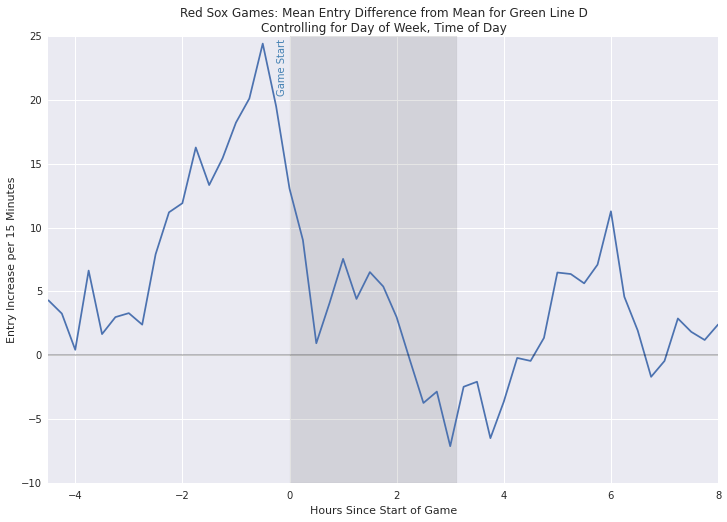

In [273]:
# Start plotting.
plt.figure(figsize=default_figsize)
plt.plot(mean_entry_differences_agg.hours_since_game_start, mean_entry_differences_agg.entries_vs_mean['mean'])

# Fix x limit and add origin lines.
xlim = plt.xlim((-4.5, plt.xlim()[1])); ylim = plt.ylim()
# plt.axvline(0, *ylim, color='lightgray')
plt.axvspan(0, game_length, color='k', alpha=0.1)
plt.axhline(0, *xlim, color='k', alpha=0.25)
plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

# Prettify.
plt.title('Red Sox Games: Mean Entry Difference from Mean for Green Line D\nControlling for Day of Week, Time of Day')
plt.xlabel('Hours Since Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
plt.ylim(ylim)

# Show.
plt.show()

That was definitely not expected. There is an early peak before the game (expected) but no post-game bump. As this represents entries on *all* above-ground D-line trains, it may be that people avoid the line when they know that a game is letting out. That ought to offset any extra rush to Fenway station.

### Inbound/Outbound

In [243]:
# Get hourly entries for all times of day on gameless days. Use name to indicate stations.
gameless_entries_io = fenway_games_io[fenway_games_io.game_played == False]
gameless_entries_io = gameless_entries_io.groupby(['day_of_week','service_time']).agg({'entries': np.mean}).reset_index()
gameless_entries_io.rename(columns={'entries':'mean_entries'}, inplace=True)

In [270]:
# Only consider entries at the time of or soon after the game.
gametime_condition = (fenway_games_io.time_since_game_start >= np.timedelta64(-270,'m')) & (fenway_games_io.time_since_game_start <= np.timedelta64(8,'h'))
game_entries_io = fenway_games_io[fenway_games_io.game_played & gametime_condition]

# Join mean entries for gameless days at that time of day.
entry_differences_io = game_entries_io.merge(gameless_entries_io, on=['day_of_week','service_time'])[['inbound','entries','time_since_game_start','mean_entries']]
entry_differences_io['entries_vs_mean'] = entry_differences_io.entries - entry_differences_io.mean_entries
entry_differences_io['entries_vs_mean_ratio'] = entry_differences_io.entries / entry_differences_io.mean_entries

# Calculate mean differences and clean up timedeltas that don't place nicely with groupings.
mean_entry_differences_io = entry_differences_io.groupby(['inbound','time_since_game_start']).agg({
        'entries_vs_mean': [np.mean,np.std],
        'entries_vs_mean_ratio': [np.mean,np.std]
    }).reset_index()
mean_entry_differences_io.time_since_game_start = pd.to_timedelta(mean_entry_differences_io.time_since_game_start)
mean_entry_differences_io['hours_since_game_start'] = mean_entry_differences_io.time_since_game_start.astype(np.int) / timedelta_base

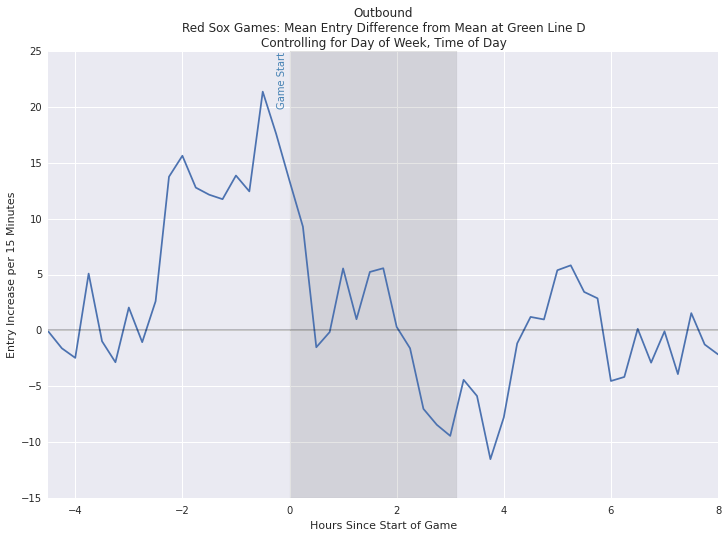

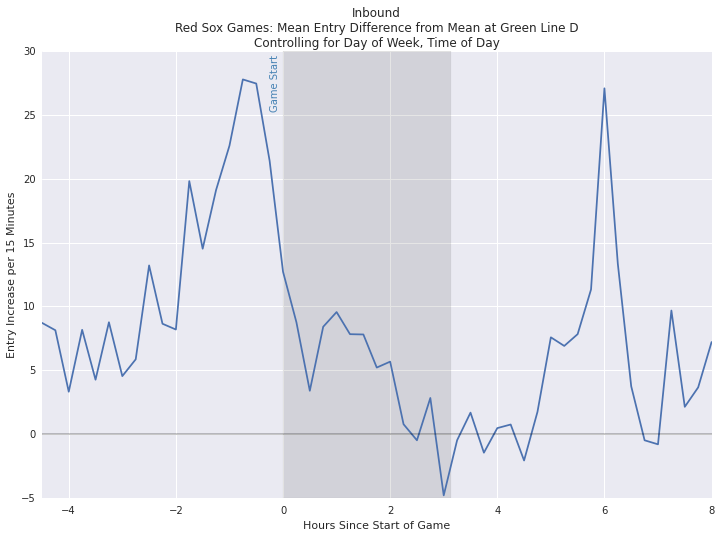

In [271]:
# One plot per direction.
for inbound in [False, True]:
    this_dir = mean_entry_differences_io[mean_entry_differences_io.inbound == inbound]
    # Start plotting.
    plt.figure(figsize=default_figsize)
    plt.plot(this_dir.hours_since_game_start, this_dir.entries_vs_mean['mean'])

    # Fix x limit and add origin lines.
    xlim = plt.xlim((-4.5, plt.xlim()[1])); ylim = plt.ylim()
    # plt.axvline(0, *ylim, color='lightgray')
    plt.axvspan(0, game_length, color='k', alpha=0.1)
    plt.axhline(0, *xlim, color='k', alpha=0.25)
    plt.annotate('Game Start', (-.05,ylim[1]*0.97), rotation='vertical', ha='right', color='steelblue')

    # Prettify.
    plt.title(('Inbound' if inbound else 'Outbound')+'\nRed Sox Games: Mean Entry Difference from Mean at Green Line D\nControlling for Day of Week, Time of Day')
    plt.xlabel('Hours Since Start of Game'); plt.ylabel('Entry Increase per 15 Minutes')
    plt.ylim(ylim)

    # Show.
    plt.show()